In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
from scipy.stats import vonmises_fisher
from scipy.optimize import minimize_scalar
from scipy.stats import genextreme
import scipy


from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.stats import wasserstein_distance

from tqdm import tqdm

## Constructing X tilde 

In [3]:
X = pd.read_csv("river_obs_from_api.csv")
X = X.dropna().reset_index(drop=True)

In [4]:
cluster_label = pd.read_csv("clusters.csv")
cluster_label.columns = X.columns
cluster_dict = cluster_label.T.groupby(0).apply(lambda x: x.index.tolist()).to_dict()

In [5]:
GPD_parameters = pd.read_csv('GPD_parameters.csv')
GPD_parameters = GPD_parameters.set_index( "Unnamed: 0")

In [6]:
normalization_params = pd.DataFrame()
normalization_params.index = ['mean', 'std']

normalized_X = X.copy()

for col in X.columns:
    _mean , _std = X[col].mean(), X[col].std()
    normalization_params[col] = np.array([_mean, _std])
    normalized_X[col] = (normalized_X[col] - _mean)/_std

In [7]:
X_tilde = pd.DataFrame().reindex_like(X)

GPD_dict = dict()
for key, values in cluster_dict.items():
    data = []
    for col in values:
        data_col = normalized_X[col]
        u_col = np.nanpercentile(data_col, 94)
        data_col = data_col[data_col >u_col]
        data.extend(data_col.to_list())
    data = np.array(data)
    shape, loc, scale = GPD_parameters.loc[key]['shape'], GPD_parameters.loc[key]['loc'], GPD_parameters.loc[key]['scale']
    u = loc
    GPD_dict[key] = [shape, loc, scale, u]

    for col in values:
        data = normalized_X[col]
        n = len(data)
        empirical = 1/n * np.argsort(np.argsort(data))
        empirical[data > u] = 0
        GPD_pdf = (1 - np.max(empirical))* stats.genpareto.cdf(data, shape, loc, scale) + np.max(empirical)
        GPD_pdf[data < u] = 0
        X_tilde[col] = (-np.log(empirical + GPD_pdf))**(-1/2)

In [8]:
X_tilde.to_csv('X_tilde.csv', index = False)

## Clusters

In [10]:
X = pd.read_csv("river_obs_from_api.csv")
X = X.dropna().reset_index(drop=True)

In [11]:
scaler = StandardScaler()
X_stand = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [12]:
#### build clusters based on the similarities of the distribution of the gauges

def distance_matrix(X):

    distances = np.zeros((X.shape[1], X.shape[1]))
    datas = X.to_numpy()
    
    for i in range(distances.shape[0]):
        for j in range(distances.shape[0]):
            distances[i,j] = wasserstein_distance(datas[:,i], datas[:,j])
            distances[j,i] = distances[i,j]
    return distances

def distance_matrix_extreme(X):

    distances = np.zeros((X.shape[1], X.shape[1]))
    datas_noextr = X.to_numpy()
    datas = np.zeros((100,datas_noextr.shape[1]))
    for k in range(datas_noextr.shape[1]):
        indices_of_max_values = np.argsort(datas_noextr[:,k])[-100:]
        datas[:,k] = datas_noextr[:,k][indices_of_max_values]
    
    for i in range(distances.shape[0]):
        for j in range(distances.shape[0]):
            distances[i,j] = wasserstein_distance(datas[:,i], datas[:,j])
            distances[j,i] = distances[i,j]
    return distances

In [13]:
distance = distance_matrix(X_stand)
linkage_matrix = linkage(squareform(distance), method='ward')

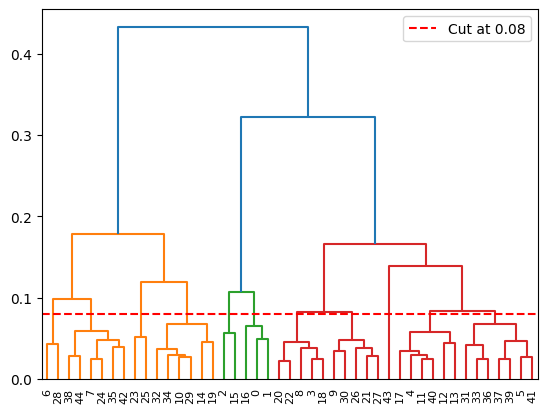

In [17]:
cluster_height = 0.08
dendrogram(linkage_matrix)
plt.axhline(y=cluster_height, color='r', linestyle='--', label=f'Cut at {cluster_height}')
plt.legend()
#plt.savefig("dendrogram")
plt.show()

In [18]:
# Choose a height based on the dendrogram
cluster_height = 0.08 # Adjust this based on your dendrogram

# Assign data points to clusters
clusters = fcluster(linkage_matrix, t=cluster_height, criterion='distance')
np.max([(clusters == k).sum() for k in range(1,9)]), np.min([(clusters == k).sum() for k in range(1,9)]), np.unique(clusters).shape

(6, 2, (11,))

In [19]:
dic_clusters = {}
for gauge in range(45):
    dic_clusters[gauge] = clusters[gauge]
dic_clusters

{0: 6,
 1: 6,
 2: 5,
 3: 7,
 4: 9,
 5: 10,
 6: 1,
 7: 2,
 8: 7,
 9: 8,
 10: 4,
 11: 9,
 12: 9,
 13: 9,
 14: 4,
 15: 5,
 16: 6,
 17: 9,
 18: 7,
 19: 4,
 20: 7,
 21: 8,
 22: 7,
 23: 3,
 24: 2,
 25: 3,
 26: 8,
 27: 8,
 28: 1,
 29: 4,
 30: 8,
 31: 10,
 32: 4,
 33: 10,
 34: 4,
 35: 2,
 36: 10,
 37: 10,
 38: 2,
 39: 10,
 40: 9,
 41: 10,
 42: 2,
 43: 11,
 44: 2}

In [20]:
dic_clusters_manual = dic_clusters.copy()
dic_clusters_manual[6], dic_clusters_manual[28] = dic_clusters[38], dic_clusters[38]
dic_clusters_manual[23], dic_clusters_manual[25] = dic_clusters[32], dic_clusters[32]
dic_clusters_manual[43] = dic_clusters[40]
print("Number of clusters: ", np.unique(np.array(list(dic_clusters_manual.values()))).shape[0])


Number of clusters:  8


In [21]:
#save the dict as a csv

import csv

csv_file_path = 'clusters.csv'

# Specify the fieldnames (column headers) based on your dictionary keys
fieldnames = dic_clusters_manual.keys()

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a DictWriter object
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header row
    writer.writeheader()

    # Write the data row
    writer.writerow(dic_clusters_manual)

## PCA

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
X = pd.read_csv("X_tilde.csv")
X = X.dropna().reset_index(drop=True)

In [11]:
def derive_TPDM(X, q, u=0):
    K = X.shape[1]

    rad = np.sqrt(np.sum(X**2, axis=1))
    if u == 0:
        u = np.quantile(rad, q)

    ind = np.where(rad > u)[0]
    ang = X.iloc[ind, :].copy().to_numpy()  # Convert ang to NumPy array

    rad_ind = rad[ind].to_numpy().reshape(-1, 1)  # Convert rad to NumPy array
    ang /= rad_ind

    S = (K / len(ind)) * np.dot(ang.T, ang)

    return S

In [12]:
Sigma = derive_TPDM(X, q=0.94)

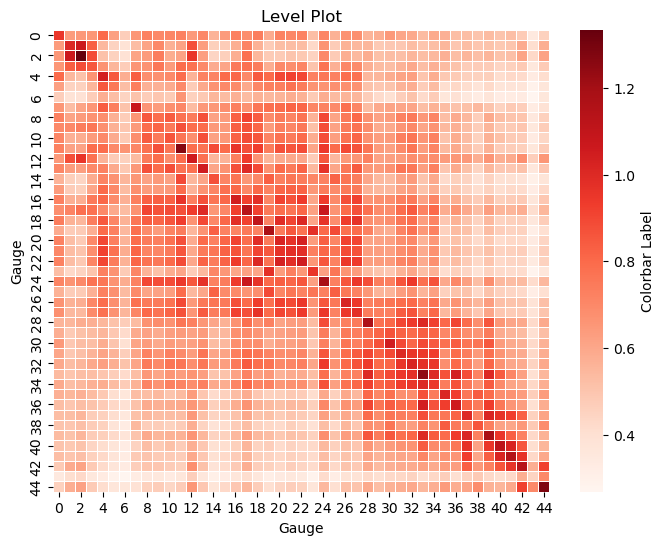

In [13]:
cuts = 8

# Create a level plot
plt.figure(figsize=(8, 6))
sns.heatmap(Sigma, cmap="Reds", cbar_kws={'label': 'Colorbar Label'}, annot=False, fmt=".2f", linewidths=.5)
plt.title('Level Plot')
plt.xlabel('Gauge')
plt.ylabel('Gauge')
plt.show()

In [14]:
eigenvalues, eigenvectors = np.linalg.eigh(Sigma)

# Eigenvalues are in ascending order, so reverse them
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[:, ::-1]

# The eigenvectors are stored as columns in the matrix
U = eigenvectors
D = np.diag(eigenvalues)

# Print or use U and D as needed
print("Eigenvectors (U):")
print(U)
print("\nEigenvalues (D):")
print(D)

Eigenvectors (U):
[[ 0.14343098 -0.05795474 -0.10428927 ...  0.07948945  0.01284297
   0.05517039]
 [ 0.1307511   0.0292963  -0.4073631  ... -0.01643294  0.0958723
  -0.15667454]
 [ 0.13586972  0.05327348 -0.49131156 ... -0.04807123 -0.00757366
  -0.07725526]
 ...
 [ 0.12723918  0.23413046 -0.1734389  ... -0.01562311  0.00968221
   0.03128659]
 [ 0.08901698  0.105192   -0.10419498 ...  0.08063993  0.07223249
  -0.21877799]
 [ 0.12132521  0.1807141  -0.21075381 ... -0.01858879 -0.05982502
   0.09215698]]

Eigenvalues (D):
[[2.92028394e+01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.52702747e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.26062747e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.40581316e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.10

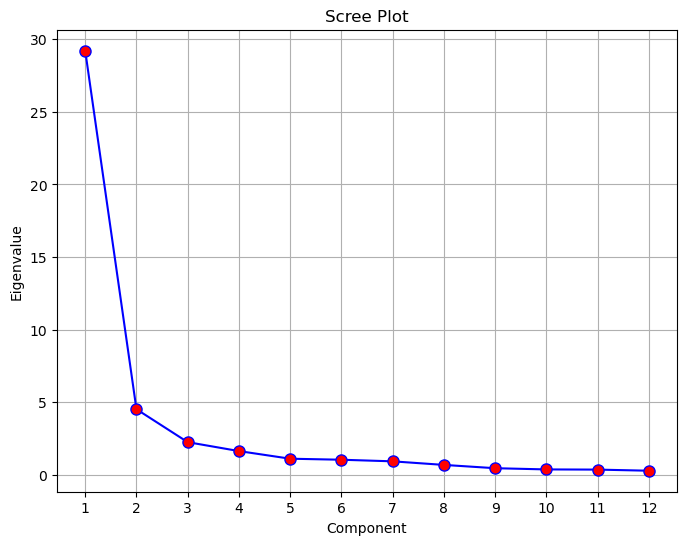

In [15]:
# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 13), eigenvalues[0:12], marker='o', linestyle='-', color='b', markerfacecolor='r', markersize=8)
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

## Sampling $W$ and $\widetilde{X}$

In [16]:
import numpy as np

def von_mises_fisher_pdf(x, mu, kappa):
    dot_product = np.dot(x, mu.T)  # Transpose mu
    normalization_const = von_mises_fisher_normalization_constant(len(mu.T), kappa)
    pdf_values = normalization_const * np.exp(kappa * dot_product)
    return pdf_values

def von_mises_fisher_normalization_constant(d, kappa):
    bessel_term = scipy.special.iv(d/2 - 1, kappa)
    constant = (kappa**(d/2 - 1)) / ((2 * np.pi)**(d/2) * bessel_term) 
    return constant

def _costFunction(bw, x):
    n_samples = len(x)

    pdf_values = von_mises_fisher_pdf(x, x, kappa=bw)
    mask = ~np.eye(n_samples, dtype=bool)
    pdf_values_without_current = pdf_values[mask].reshape(n_samples, n_samples-1)
    mean_pdf_values = pdf_values_without_current.mean(axis=1)
    log_mean_pdf_values = np.log(mean_pdf_values)
    result = -log_mean_pdf_values.mean(axis=0)

    return result

def kappaEstimation(x, lower=0.1, upper=500, xatol=1e-05):
    if len(x) < 2:
        raise Exception("Need at least 2 data points")
    bw = minimize_scalar(_costFunction, args=(x), bounds=(lower, upper),
                         method="Bounded", options={'maxiter': 500, 'xatol': xatol})
    return bw.x


In [17]:
def sample_W(n, m, W, seed=500):
    K = W.shape[1]
    J = W.shape[0]

    np.random.seed(seed)

    # Derive values for Z
    Z = np.column_stack([W[:, :m], np.where(W[:, m] < 0, -1, 1)])
    Z[:, m] = np.sqrt(1 - np.sum(Z[:, :m] ** 2, axis=1)) * Z[:, m]

    # Sample values for lower-dimensional variable Z
    kappa = kappaEstimation(Z)
    z_samp = mixvmf(n, Z, np.ones(J) * kappa)

    # Derive nearest neighbour
    q = np.argmax(np.dot(z_samp, Z.T), axis=1)

    # Map Z to high-dimensional space of W
    w_samp = np.zeros((n, K))
    w_samp[:, :m] = z_samp[:, :m]
    w_samp[:, m:] = np.abs(z_samp[:, m][:, np.newaxis] / Z[q, m][:, np.newaxis]) * W[q, m:]

    return w_samp

def mixvmf(n, mu, k):
    num_groups = len(mu)
    group_indices = np.random.randint(0, num_groups, size=n)
    x_matrix = np.zeros((n, mu.shape[1]))

    for i in range(num_groups):
        group_mask = (group_indices == i)
        group_size = np.sum(group_mask)

        if group_size > 0:
            x_matrix[group_mask, :] = vonmises_fisher.rvs(mu[i, :], k[i], size=group_size)

    return x_matrix

In [18]:
def tf(x):
    y = x.copy()
    y[y < 600] = np.log(1 + np.exp(y[y < 600]))
    return y

def tf_inv(y):
    x = y.copy()
    x[x < 600] = np.log(np.exp(x[x < 600]) - 1)
    return x

def density_frechet(x, K=45):
    
    return 2 * K**2 * (1/x**3) * np.exp(-(x / K)**-2)

def inverse_cdf_frechet(y, K=45):
    return K * np.power(-np.log(y), -1/2)


def sample_X_tilde( n, m, W, U, seed=500 ):
  K = W.shape[1]

  np.random.seed(seed)

  r = inverse_cdf_frechet(np.random.uniform(size = n), K = np.sqrt(45))
  w = sample_W(n, m, W, seed=500)
  v = w * r[:, None]

  x = tf(np.dot(v, U.T))

  return x


In [19]:
n = 800
m = 6
V = np.dot(U.T, tf_inv(X).T).T
W = V / np.linalg.norm(V, axis = 1)[:, None]

K = X.shape[1]
rad = np.sqrt(np.apply_along_axis(np.sum, 1, X**2))
q = 0.94
u = np.quantile(rad, q)
ind = (rad > u)

W_filterd = W[ind]
X_tilde_filtered = X[ind]


X_tilde_sampled = sample_X_tilde( n, m, W_filterd, U)
W_sampled = sample_W(n, m, W_filterd, seed = 2)

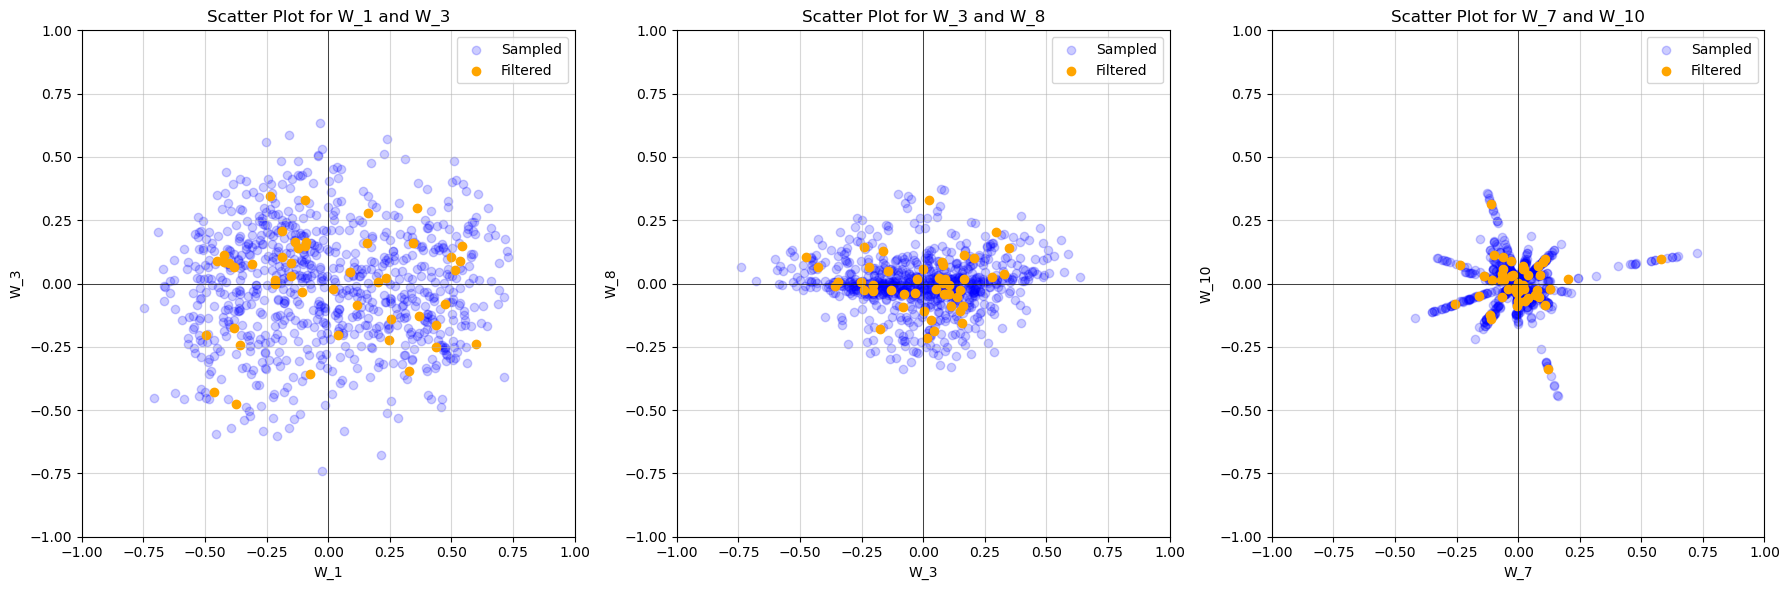

In [20]:
combinations = [(1, 3), (3, 8), (7, 10)]

fig, axs = plt.subplots(1, len(combinations), figsize=(18, 6))

for idx, (i, j) in enumerate(combinations):
    axs[idx].scatter(W_sampled[:, i], W_sampled[:, j], alpha=0.2, label='Sampled', marker='o', color='blue')
    axs[idx].scatter(W_filterd[:, i], W_filterd[:, j], label='Filtered', marker='o', color='orange')
    axs[idx].set_xlabel(f'W_{i}')
    axs[idx].set_ylabel(f'W_{j}')
    axs[idx].set_title(f'Scatter Plot for W_{i} and W_{j}')
    axs[idx].legend()
    axs[idx].set_xlim([-1, 1])
    axs[idx].set_ylim([-1, 1])
    axs[idx].grid(alpha = 0.5)
    axs[idx].axhline(0, color='black', linewidth=0.5)
    axs[idx].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

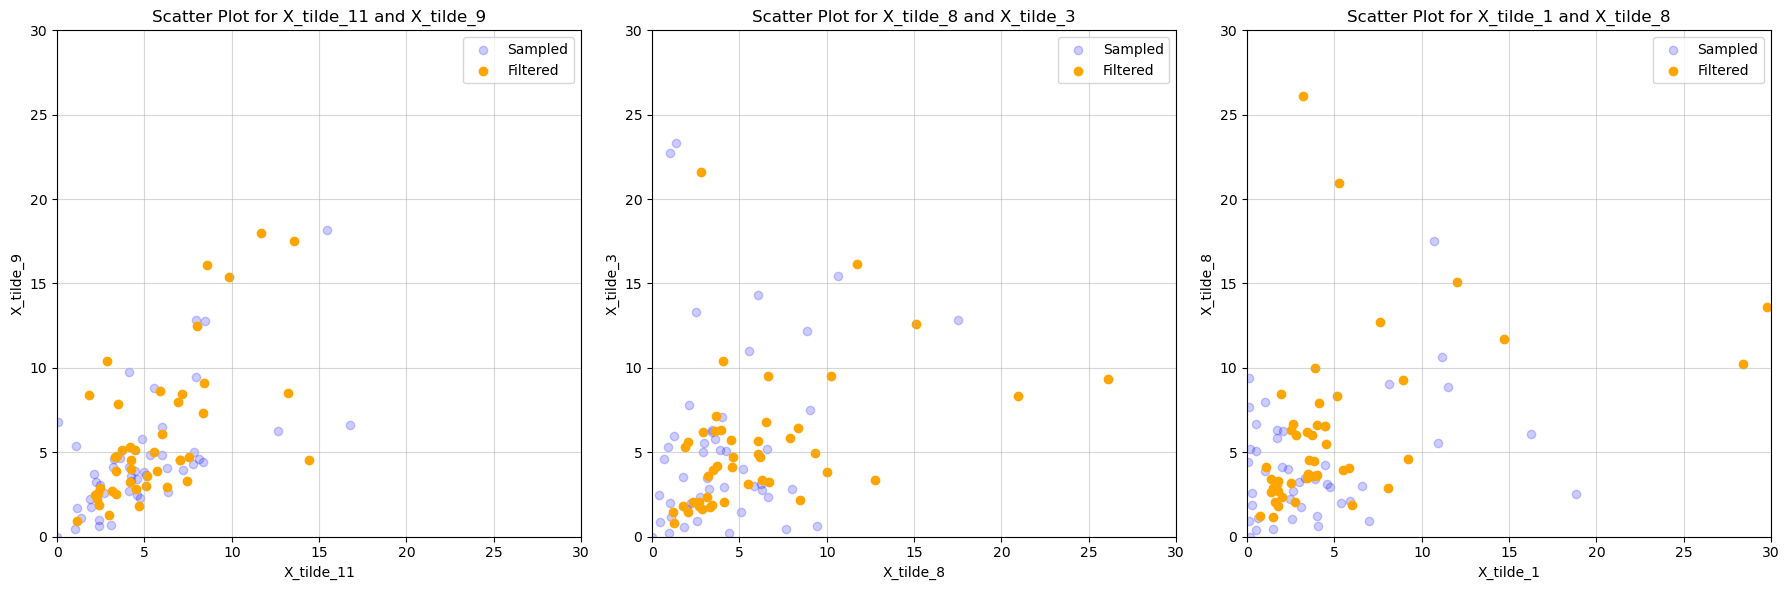

In [21]:
combinations = [(11, 9), (8, 3), (1, 8)]

fig, axs = plt.subplots(1, len(combinations), figsize=(18, 6))
X_np = X.to_numpy()[ind]

X_tilde_sampled_np = X_tilde_sampled.copy()
rad =  np.linalg.norm(X_tilde_sampled_np, axis = 1)
q = 0.94
u = np.nanquantile(rad, q)
ind2 = (rad > u)
X_tilde_sampled_np = X_tilde_sampled_np[ind2]

for idx, (i, j) in enumerate(combinations):
    axs[idx].scatter(X_tilde_sampled_np[:, i], X_tilde_sampled_np[:, j], alpha=0.2, label='Sampled', marker='o', color='blue')
    axs[idx].scatter(X_np[:, i], X_np[:, j], label='Filtered', marker='o', color='orange')
    axs[idx].set_xlabel(f'X_tilde_{i}')
    axs[idx].set_ylabel(f'X_tilde_{j}')
    axs[idx].set_title(f'Scatter Plot for X_tilde_{i} and X_tilde_{j}')
    axs[idx].legend()
    axs[idx].set_xlim([0, 30])
    axs[idx].set_ylim([0, 30])
    axs[idx].grid(alpha = 0.5)
    axs[idx].axhline(0, color='black', linewidth=0.5)
    axs[idx].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

## Inverting $\hat{X}$ to get $X$

In [22]:
inverted_dict = {element: key for key, value in cluster_dict.items() for element in value}

In [23]:
X_tilde_sampled = sample_X_tilde( 4400, m, W_filterd, U)

In [24]:
X = pd.read_csv("river_obs_from_api.csv")
X = X.dropna().reset_index(drop=True)
X_tilde_sampled = pd.DataFrame(X_tilde_sampled, columns = X.columns)

In [25]:
X_obs_sampled = pd.DataFrame()

for col in X_tilde_sampled.columns:
    column = X_tilde_sampled[col]
    data = normalized_X[col]
    
    probabilities = np.exp(- column**(-2))
    sorted_data = np.sort(data)
    ecdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    indices = np.searchsorted(ecdf_values, probabilities, side='right')
    results = sorted_data[np.minimum(indices, len(sorted_data) - 1)]
    
    
    clust = inverted_dict[col]
    shape, loc, scale, u = GPD_dict[clust]
    results[probabilities> 0.94] = stats.genpareto.ppf((probabilities[probabilities> 0.94] - 0.94)/(1-0.94), shape, loc, scale)

    mean, std = normalization_params[col]
    X_obs_sampled[col] = results * std + mean

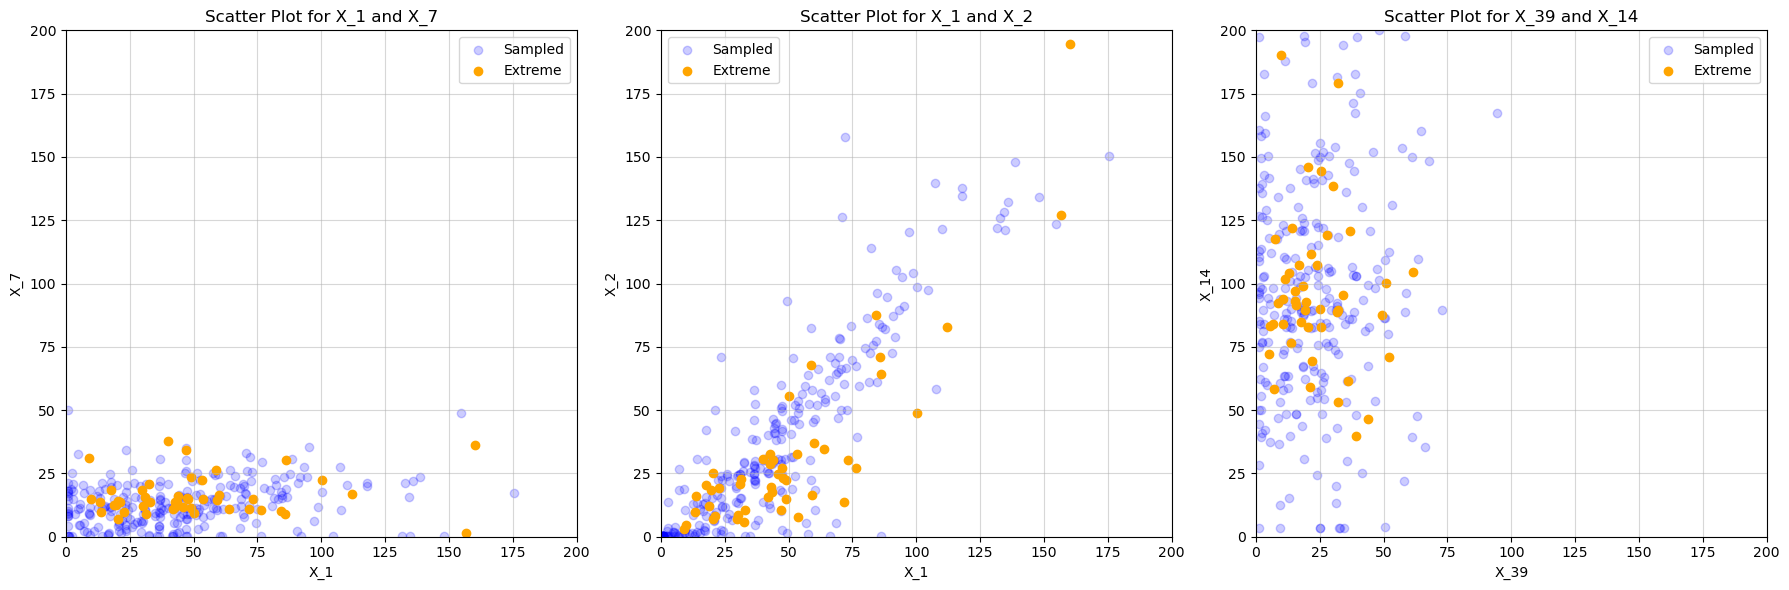

In [26]:
combinations = [(1, 7), (1, 2), (39, 14)]

fig, axs = plt.subplots(1, len(combinations), figsize=(18, 6))

X_np = X.to_numpy()
rad =  np.linalg.norm(X_np, axis = 1)
q = 0.94
u = np.nanquantile(rad, q)
ind = (rad > u)
X_np = X_np[ind]

X_obs_sampled_np = X_obs_sampled.to_numpy()
rad =  np.linalg.norm(X_obs_sampled_np, axis = 1)
q = 0.94
u = np.nanquantile(rad, q)
ind = (rad > u)
X_obs_sampled_np = X_obs_sampled_np[ind]

for idx, (i, j) in enumerate(combinations):
    axs[idx].scatter(X_obs_sampled_np[:, i], X_obs_sampled_np[:, j], alpha=0.2, label='Sampled', marker='o', color='blue')
    axs[idx].scatter(X_np[:, i], X_np[:, j], label='Extreme', marker='o', color='orange')
    axs[idx].set_xlabel(f'X_{i}')
    axs[idx].set_ylabel(f'X_{j}')
    axs[idx].set_title(f'Scatter Plot for X_{i} and X_{j}')
    axs[idx].legend()
    axs[idx].set_xlim([0, 200])
    axs[idx].set_ylim([0, 200])
    axs[idx].grid(alpha = 0.5)
    axs[idx].axhline(0, color='black', linewidth=0.5)
    axs[idx].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

## Estimation of m


In [900]:

from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing
X = pd.read_csv("X_tilde.csv")
ind = X.dropna().index
X = X.loc[ind]

K = X.shape[1]
rad = np.linalg.norm(X, axis=1)
q = 0.94
u = np.quantile(rad, q)
ind = rad > u

X = X[ind]
R = np.linalg.norm(X, axis=1)
n = ind.sum()

m_max = 30
nSim = 35
nSam = 2000

# Using Manager to create shared memory for D_i
manager = multiprocessing.Manager()
D_i_shared = manager.list([manager.list([manager.list([0.0] * m_max) for _ in range(nSim)]) for _ in range(n)])

def loocv_iteration(i, D_i_shared):
    X_i = np.delete(X.to_numpy(), i, axis=0)

    Sigma_i = derive_TPDM(pd.DataFrame(X_i), q, u=1e-10)
    estim = np.linalg.eig(Sigma_i)

    # Derive angular component of V
    U_i = estim[1]  # Assuming you want the eigenvectors
    V_i = np.dot(U_i.T, tf_inv(X_i).T).T
    W_i = V_i / np.linalg.norm(V_i, axis=1)[:, None]

    for m in range(1, m_max + 1):
        for j in range(nSim):
            X_samp = sample_X_tilde(nSam, m, W_i, U_i, seed=160 * j)
            X_samp = X_samp / np.linalg.norm(X_samp, axis=1)[:, None]

            D_i_shared[i][j][m-1] = 1 - np.max(np.dot(X.to_numpy()[i, :] / R[i], X_samp.T))

Parallel(n_jobs=-1)(delayed(loocv_iteration)(i, D_i_shared) for i in tqdm(range(n)))

D_i = np.array(D_i_shared)

D = np.zeros((3, m_max))

for m in range(1, m_max + 1):
    bar_D = np.nanmean(D_i[:, :,m - 1], axis=0)
    D[0, m - 1] = np.mean(bar_D)
    D[1, m - 1] = np.percentile(bar_D, 5)
    D[2, m - 1] = np.percentile(bar_D, 95)

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [08:28<00:00, 10.83s/it]


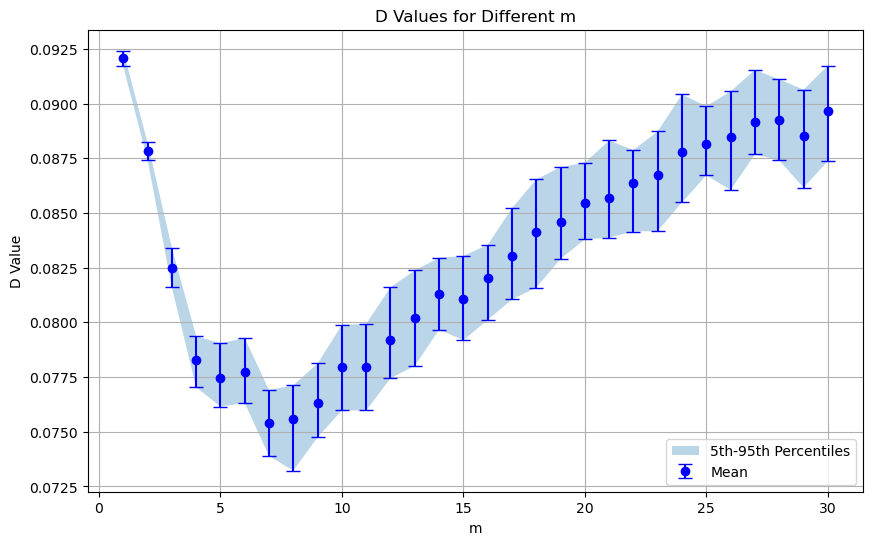

In [901]:
m_values = range(1, m_max + 1)

plt.figure(figsize=(10, 6))

plt.errorbar(m_values, D[0], yerr=[D[0] - D[1], D[2] - D[0]], label='Mean', marker='o', linestyle='', color="blue", capsize=5)
plt.fill_between(m_values, D[1], D[2], alpha=0.3, label='5th-95th Percentiles')

plt.title('D Values for Different m')
plt.xlabel('m')
plt.ylabel('D Value')
plt.legend()
plt.grid(True)
plt.show()

## Q-Q plot

In [27]:
X = pd.read_csv("river_obs_from_api.csv")
X = X.dropna().reset_index(drop=True)

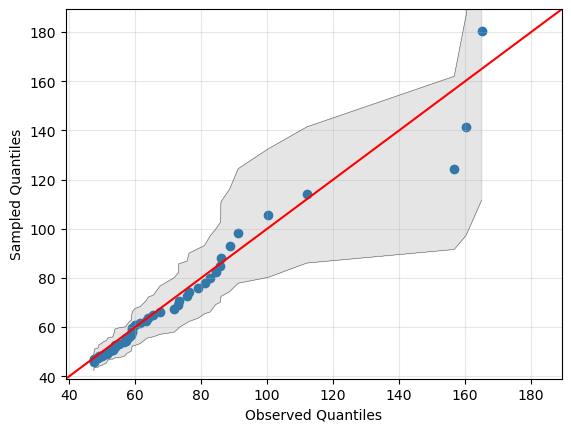

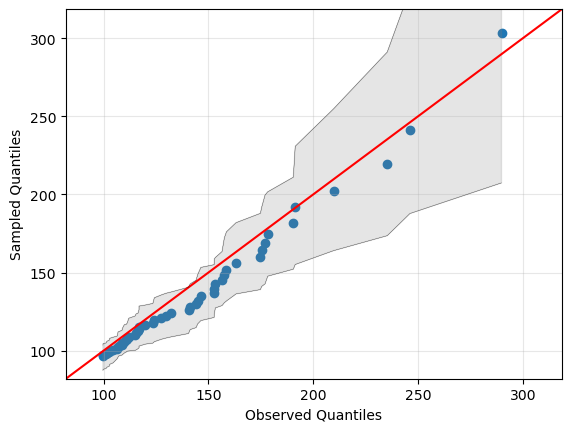

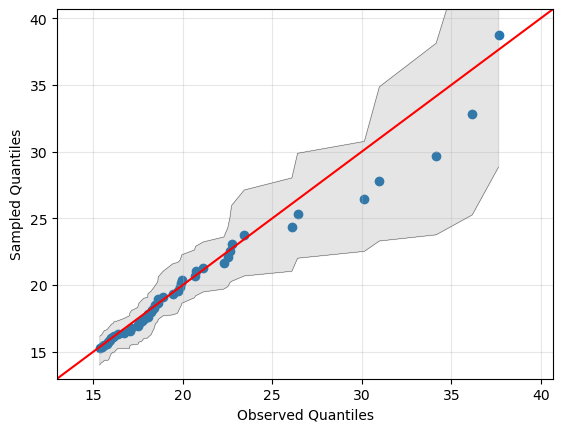

In [28]:
T = 100
weeks = 848
group_list = [[1], [4], [7]]

for group in group_list:
    top_50_T = np.zeros((T, 50))
    for n_simul in range (T):
        X_tilde_sampled = sample_X_tilde(weeks, m, W_filterd, U, seed = n_simul)
        X_tilde_sampled = pd.DataFrame(X_tilde_sampled, columns = X.columns)
        
        X_obs_sampled = pd.DataFrame()
        
        for col in X_tilde_sampled.columns:
            column = X_tilde_sampled[col]
            data = normalized_X[col]
            
            probabilities = np.exp(- column**(-2))
            sorted_data = np.sort(data)
            ecdf_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            indices = np.searchsorted(ecdf_values, probabilities, side='right')
            results = sorted_data[np.minimum(indices, len(sorted_data) - 1)]
            
            
            clust = inverted_dict[col]
            shape, loc, scale, u = GPD_dict[clust]
            results[probabilities> 0.94] = stats.genpareto.ppf((probabilities[probabilities> 0.94] - 0.94)/(1-0.94), shape, loc, scale)
        
            mean, std = normalization_params[col]
            X_obs_sampled[col] = results * std + mean
    
        temp = X_obs_sampled.to_numpy()
        
        
        top_50_T[n_simul, :] = np.sort(temp[:, group].max(axis = 1))[-50:]
    
    X_obs_np = X.to_numpy()
    top_50 = np.sort(X_obs_np[:, group].max(axis = 1))[-50:]
    
    simulated_means = np.mean(top_50_T, axis=0)
    simulated_stds = np.std(top_50_T, axis=0)
    
    lower_bound = np.percentile(top_50_T, 2.5, axis=0)
    upper_bound = np.percentile(top_50_T, 97.5, axis=0)
    
    plt.scatter(top_50, simulated_means)
    plt.plot(np.linspace(0, 10000, 10000), np.linspace(0, 10000, 10000), c ='r')
    plt.plot(top_50, lower_bound, c ='black', linewidth = 0.2)
    plt.plot(top_50, upper_bound, c ='black', linewidth = 0.2)
    plt.fill_between(top_50, lower_bound, upper_bound, color='gray', alpha=0.2)
    plt.xlim(min(np.min(top_50), np.min(simulated_means)) * 0.85, max(np.max(top_50), np.max(simulated_means)) *1.05)
    plt.ylim(min(np.min(top_50), np.min(simulated_means)) * 0.85, max(np.max(top_50), np.max(simulated_means)) *1.05)
    plt.grid(alpha = 0.3)
    plt.xlabel("Observed Quantiles")
    plt.ylabel("Sampled Quantiles")
    plt.show()